<a href="https://colab.research.google.com/github/Julio-M39/GANs_SRGAN_ESRGAN_Super_Resolucao/blob/main/GANs_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESRGAN - GAN de Super Resolução

Pontos principais:
* Foi adotado uma rede profunda que usa Residual-in-Residual Dense Block (RRDB), ao invés de camadas de batch normalization que eram usadas na SRGAN. 
* Emprega uma Relativistic average GAN ao invés de Vanilla GAN.  
* Melhora a perda perceptual através das features antes da ativação.

## Importação das bibliotecas


In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/xinntao/ESRGAN

Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Total 225 (delta 0), reused 0 (delta 0), pack-reused 225
Receiving objects: 100% (225/225), 24.86 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
%cd /content/ESRGAN

/content/ESRGAN


In [ ]:
import RRDBNet_arch as arch

## Download e carregamento do modelo pré-treinado  




Modelos disponíveis:
* RRDB_ESRGAN_x4.pth
* RRDB_PSNR_x4.pth

In [ ]:
nome_modelo = 'RRDB_ESRGAN_x4.pth'

In [ ]:
dir_modelos = 'models/'

In [ ]:
print(dir_modelos, nome_modelo)

models/ RRDB_ESRGAN_x4.pth


In [ ]:
ambiente = 'cuda' # cpu
device = torch.device(ambiente)

In [ ]:
!nvidia-smi

Fri Sep 30 13:41:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Modelos pré-treinados do ESRGAN [aqui](https://drive.google.com/drive/u/0/folders/17VYV_SoZZesU6mbxz2dMAIccSSlqLecY). Se em algum momento esses links não funcionarem, você pode encontrar os modelos nesse link: https://github.com/xinntao/ESRGAN#test-models


In [ ]:
import gdown

In [ ]:
modelo_1 = '{}RRDB_ESRGAN_x4.pth'.format(dir_modelos)
modelo_2 = '{}RRDB_PSNR_x4.pth'.format(dir_modelos)

In [ ]:
modelo_1, modelo_2

('models/RRDB_ESRGAN_x4.pth', 'models/RRDB_PSNR_x4.pth')

In [ ]:
gdown.download('https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene', modelo_1)
gdown.download('https://drive.google.com/uc?id=1pJ_T-V1dpb1ewoEra1TGSWl5e6H7M4NN', modelo_2)

Downloading...
From: https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene
To: /content/ESRGAN/models/RRDB_ESRGAN_x4.pth
100%|██████████| 66.9M/66.9M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pJ_T-V1dpb1ewoEra1TGSWl5e6H7M4NN
To: /content/ESRGAN/models/RRDB_PSNR_x4.pth
100%|██████████| 66.9M/66.9M [00:00<00:00, 230MB/s]


'models/RRDB_PSNR_x4.pth'


Mais sobre a função e seus parâmetros: https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

Documentação PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


In [ ]:
def carregar_modelo(nome_modelo, dir_modelos, device):
  modelo_caminho = "{}{}".format(dir_modelos, nome_modelo)
  modelo = arch.RRDBNet(3, 3, 64, 23, gc = 32)
  modelo.load_state_dict(torch.load(modelo_caminho), strict = True)
  modelo.eval()
  modelo = modelo.to(device)
  return modelo

In [ ]:
modelo = carregar_modelo(nome_modelo, dir_modelos, device)

## Imagens de teste

In [ ]:
dir_imagens = '/content/ESRGAN/LR/'

In [ ]:
# montanha, urbano, lego, flores, simpsons02, islandia

In [ ]:
img_nome = "{}montanha.jpg".format(dir_imagens)
img_nome

'/content/ESRGAN/LR/montanha.jpg'

In [ ]:
img = cv2.imread(img_nome)
img.shape

(320, 380, 3)

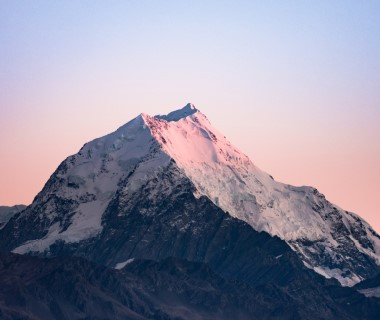

In [ ]:
cv2_imshow(img)

## Super Resolução

In [ ]:
def super_resolucao(imagem_path, device, modelo):
  base = os.path.splitext(os.path.basename(imagem_path))[0]
  #print(base)
  img = cv2.imread(imagem_path)
  img = img * 1.0 / 255
  #print(img.shape)
  img = torch.from_numpy(np.transpose(img[:,:, [2,1,0]], (2,0,1))).float()
  #print(img.shape)
  LR = img.unsqueeze(0)
  #print(LR.shape)
  LR = LR.to(device)

  with torch.no_grad():
    resultado = modelo(LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
  resultado = np.transpose(resultado[[2,1,0], :, :], (1,2,0))
  resultado = (resultado * 255.0).round()
  cv2.imwrite('results/{:s}_sr.png'.format(base), resultado)
  return resultado

In [ ]:
resultado_sr = super_resolucao(img_nome, device, modelo)
print(resultado_sr.shape)
cv2_imshow(resultado_sr)

## Avaliação do resultado

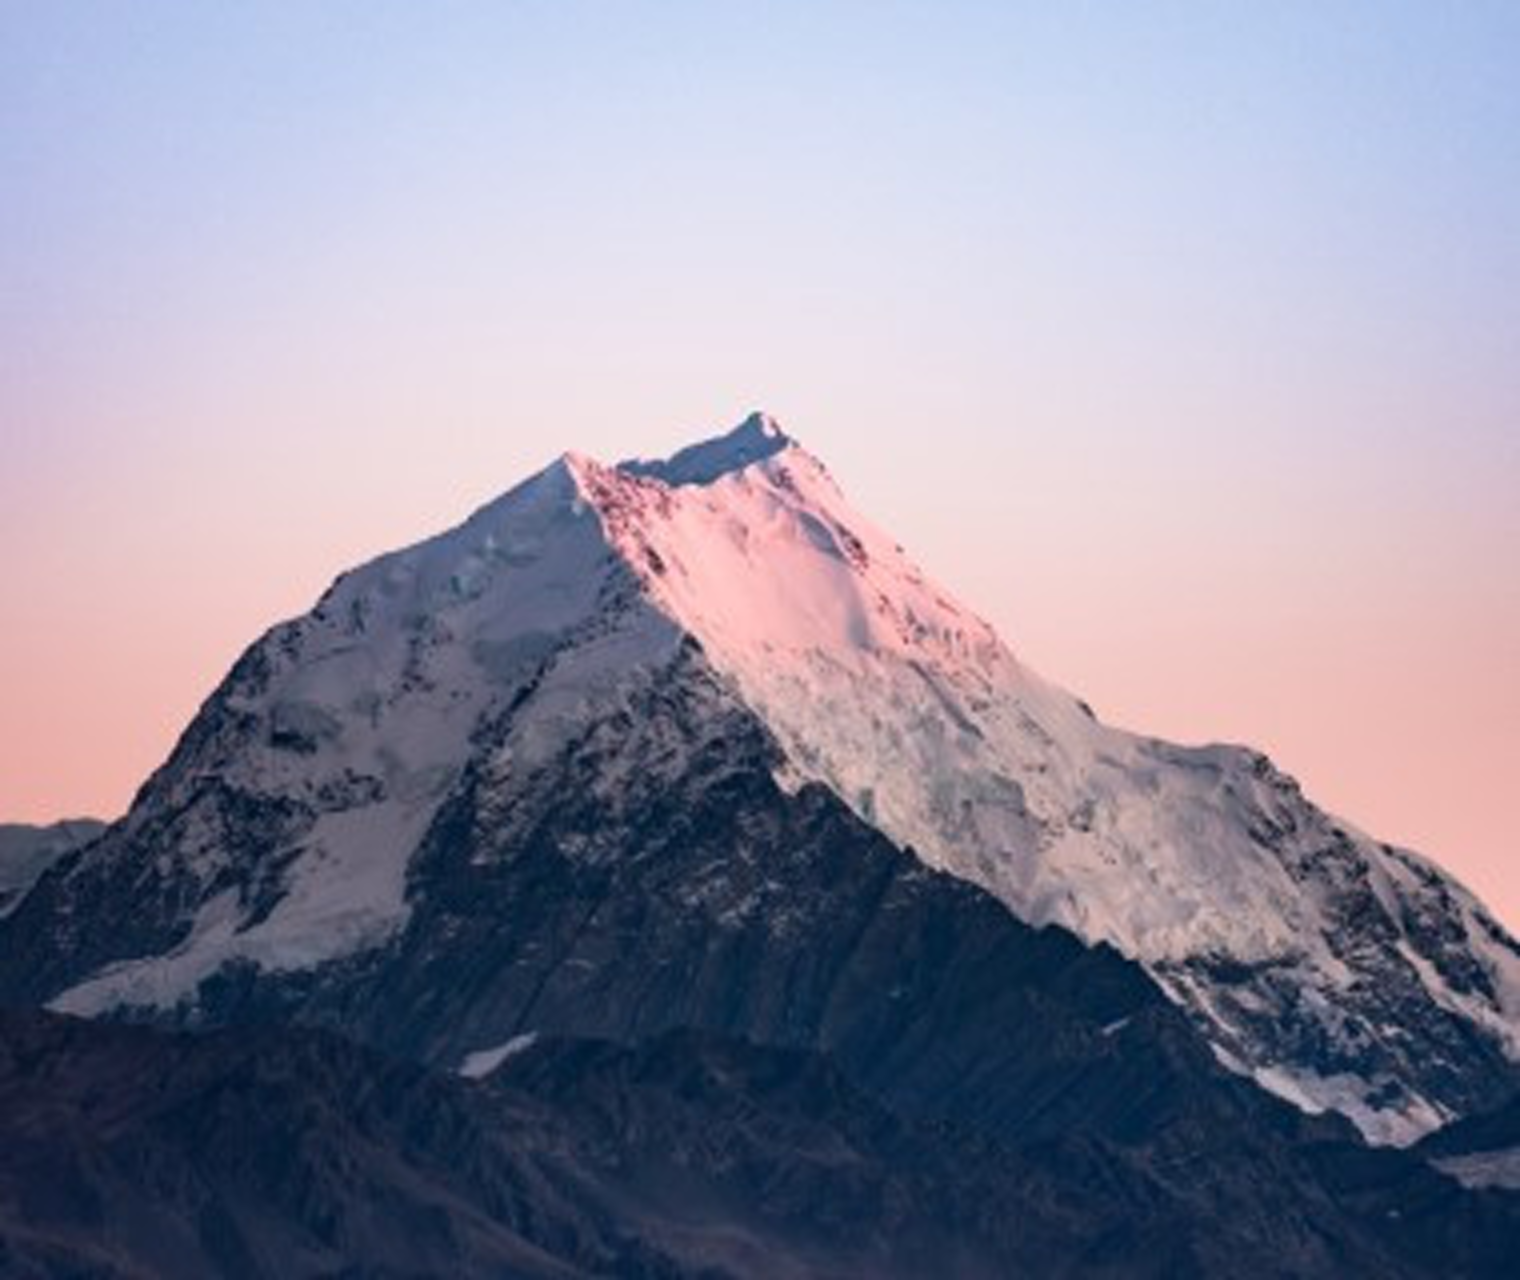

In [ ]:
img = cv2.imread(img_nome)
resultado_bicubic = cv2.resize(img, (0,0), fx = 4.0, fy = 4.0, interpolation=cv2.INTER_CUBIC)
cv2_imshow(resultado_bicubic)

### Artefatos

- Mais sobre: https://en.wikipedia.org/wiki/Compression_artifact



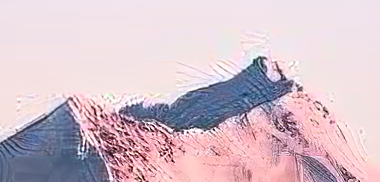

## PSNR

Peak Single to Noise Ratio ([PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) é uma das métricas mais usadas para medir a qualidade da reconstrução de imagens comprimidas por compressões sujeitas a perdas. 

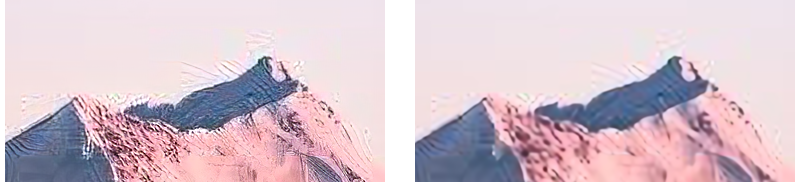

(1280, 1520, 3)


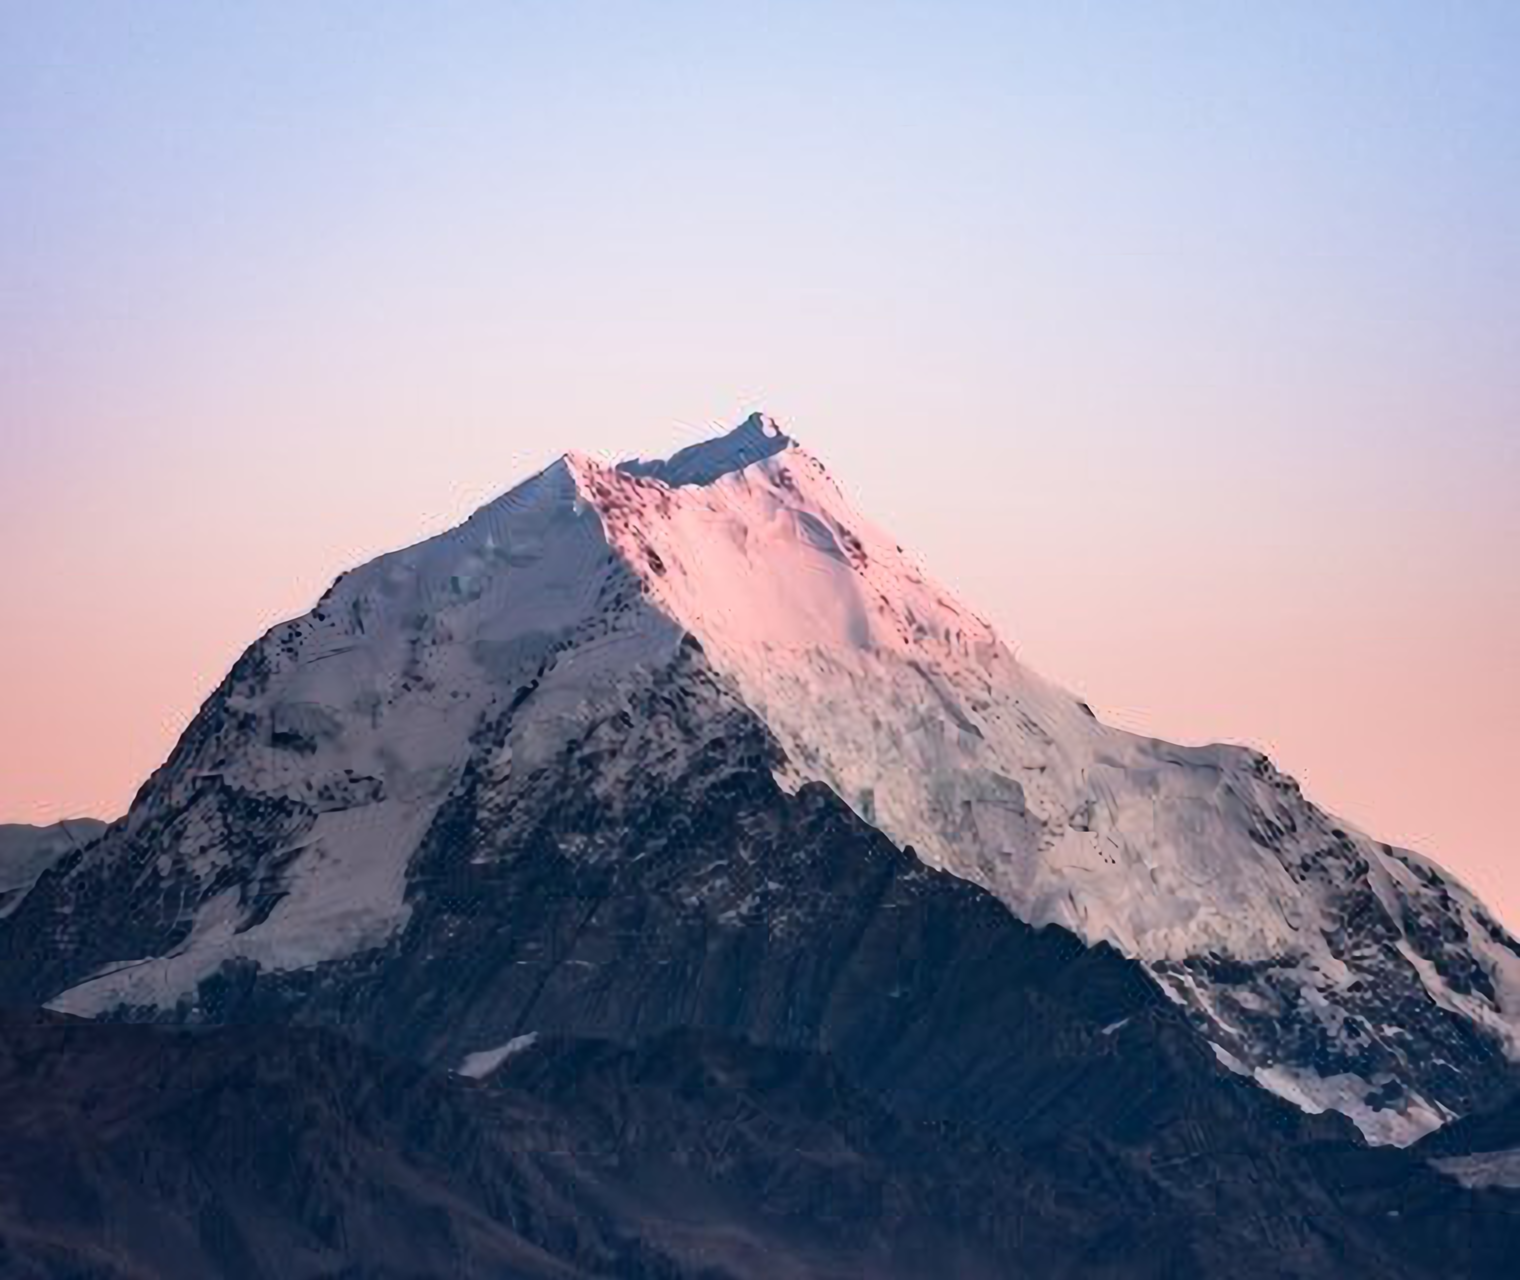

In [ ]:
nome_modelo = 'RRDB_PSNR_x4.pth'
modelo = carregar_modelo(nome_modelo, dir_modelos, device)
resultado_sr = super_resolucao(img_nome, device, modelo)
print(resultado_sr.shape)
cv2_imshow(resultado_sr)

(640, 760, 3)


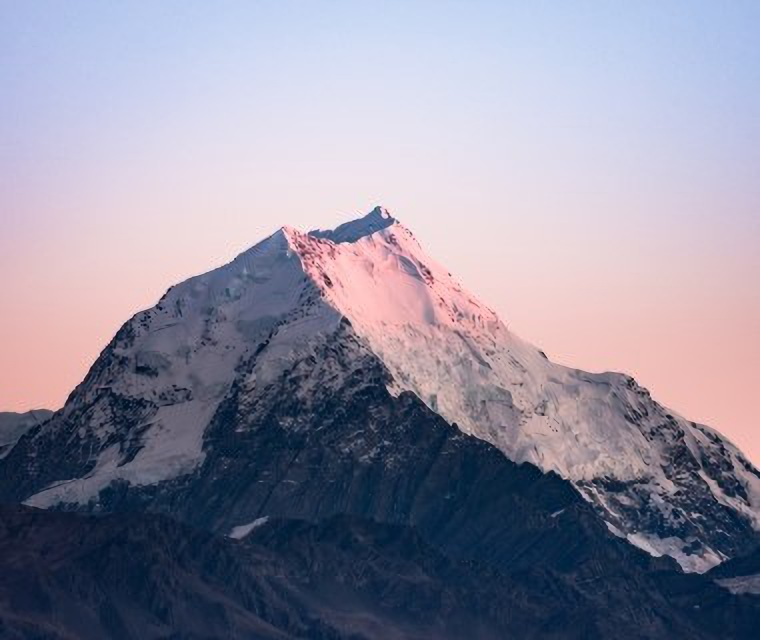

In [ ]:
resultado_menor = cv2.resize(resultado_sr, (0,0), fx = 0.5, fy = 0.5)
print(resultado_menor.shape)
cv2_imshow(resultado_menor)

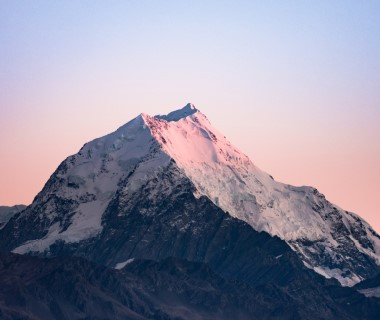

In [ ]:
cv2_imshow(img)

## Teste em múltiplas imagens

In [ ]:
diretorio = '/content/ESRGAN/LR/*'

In [ ]:
for imagem in glob.glob(diretorio):
  resultado_sr = super_resolucao(imagem, device, modelo)
  cv2_imshow(resultado_sr)

## Melhorando mais ainda os resultados



Os mesmos autores do ESRGAN publicaram uma versão ainda melhor de seu modelo. 

> https://github.com/xinntao/Real-ESRGAN

In [ ]:
!git clone https://github.com/xinntao/Real-ESRGAN.git

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 755 (delta 5), reused 14 (delta 3), pack-reused 735
Receiving objects: 100% (755/755), 5.38 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (406/406), done.


In [ ]:
%cd Real-ESRGAN

/content/ESRGAN/Real-ESRGAN


In [ ]:
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 32.7 MB/s 
     |████████████████████████████████| 6.0 MB 55.8 MB/s 
     |████████████████████████████████| 190 kB 72.3 MB/s 
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214839 sha256=d80eba5e699618e33de0e65f8ec6f5f511958960be492e3bb8068e2dfa7902fa
  Stored in directory: /root/.cache/pip/wheels/2c/b3/4a/e2bc545f98417b6766ca50dd82b2a1f2b37780c68d41da9ca9
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 5.5 MB/s 
     |████████████████████████████████| 177 kB 63.6 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=e405e1fc5d037c43808121fd1acc6ccc7282814ceab508e98b3418b3dda3eaee
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1

## Super resolução

> Parâmetro 1: modelo

Esse algoritmo aceita como parâmetro os seguintes modelos:

* RealESRGAN_x4plus (padrão)
* RealESRNet_x4plus
* RealESRGAN_x4plus_anime_6B
* RealESRGAN_x2plus
* realesr-animevideov3
* realesr-general-x4v3

> Parâmetro 2: pasta onde as imagens de teste estão

> Parâmetro 3: escala da super resolução (em quanto será aumentada)



In [ ]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i ../LR --outscale 4

Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/ESRGAN/Real-ESRGAN/weights/RealESRGAN_x4plus.pth

100% 63.9M/63.9M [00:00<00:00, 300MB/s]
Testing 0 baboon
Testing 1 comic
Testing 2 flores
Testing 3 islandia
Testing 4 lego
Testing 5 montanha
Testing 6 simpsons02
Testing 7 urbano


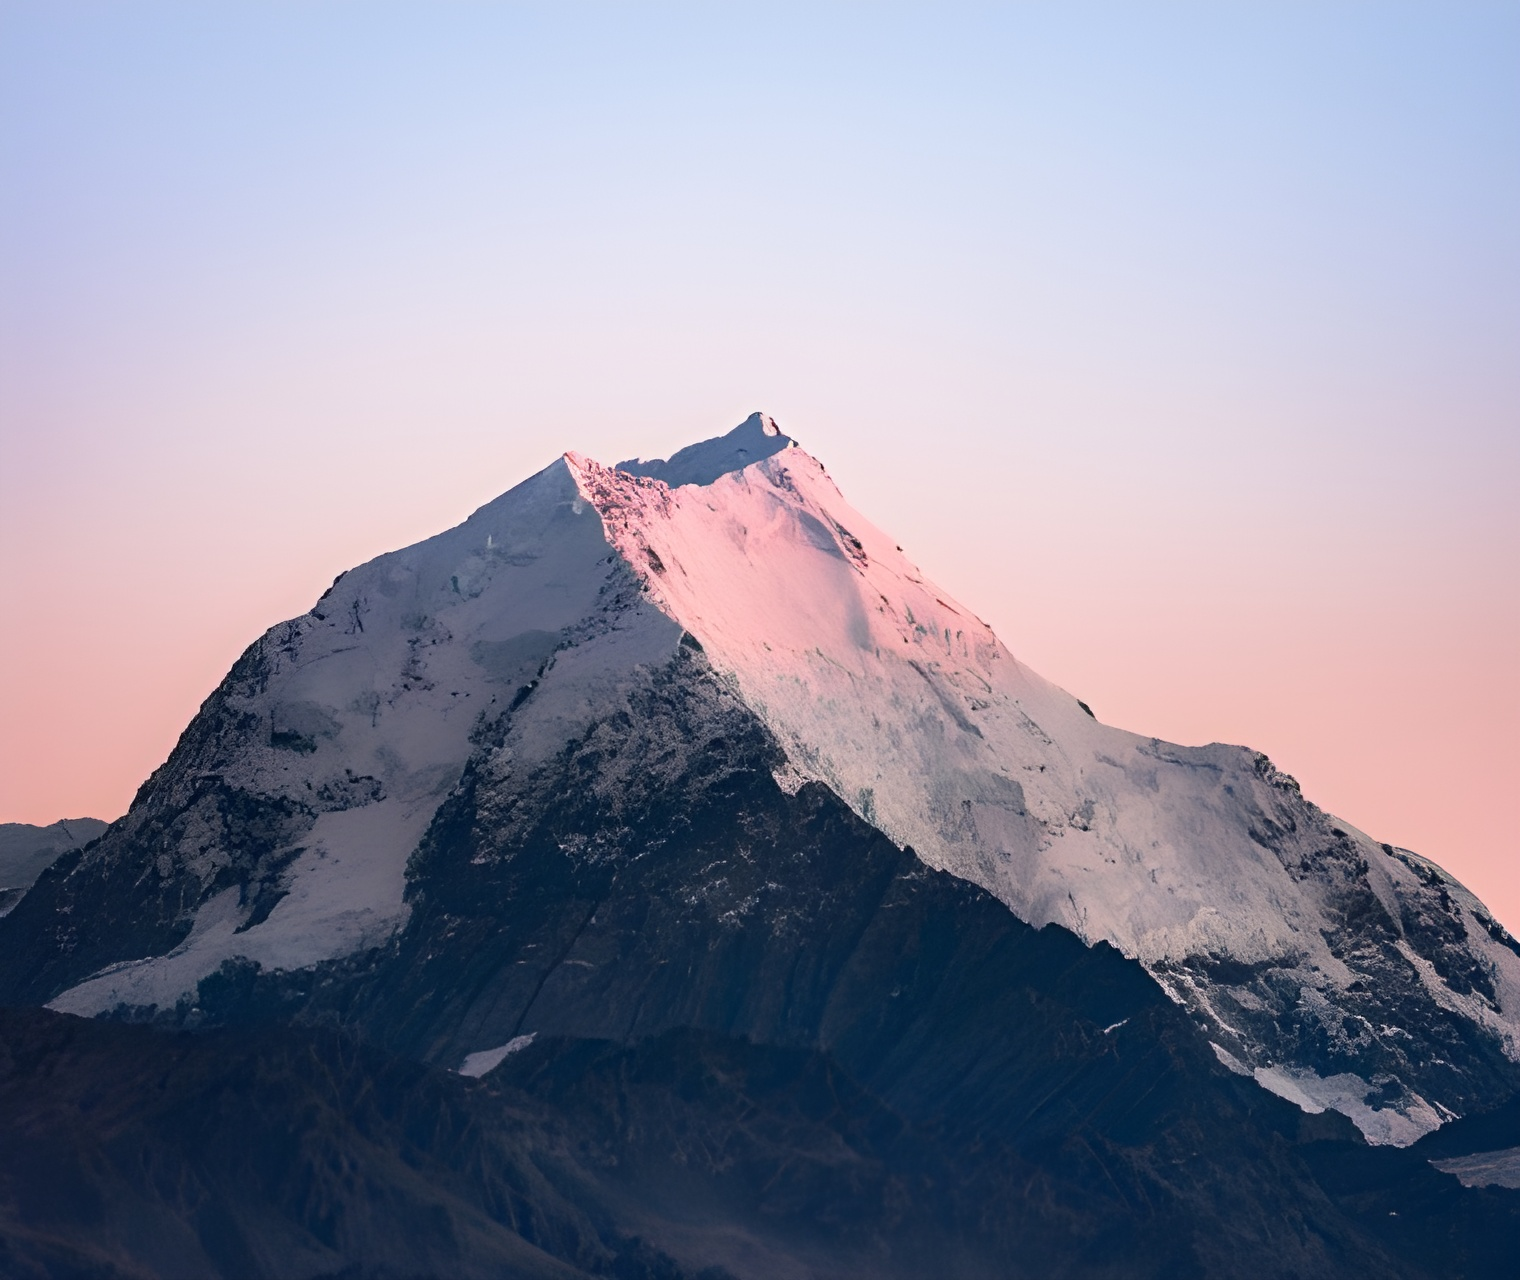

In [ ]:
img_resultado = cv2.imread('results/montanha_out.jpg')
cv2_imshow(img_resultado)

In [ ]:
img_original = cv2.imread('../LR/islandia.jpg')
img_resultado = cv2.imread('results/islandia_out.jpg')
cv2_imshow(img_original)
cv2_imshow(img_resultado)

In [ ]:
img_original = cv2.imread("../LR/lego.jpg")
img_resultado = cv2.imread("results/lego_out.jpg")
cv2_imshow(img_original)
cv2_imshow(img_resultado)

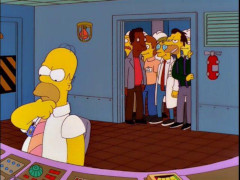

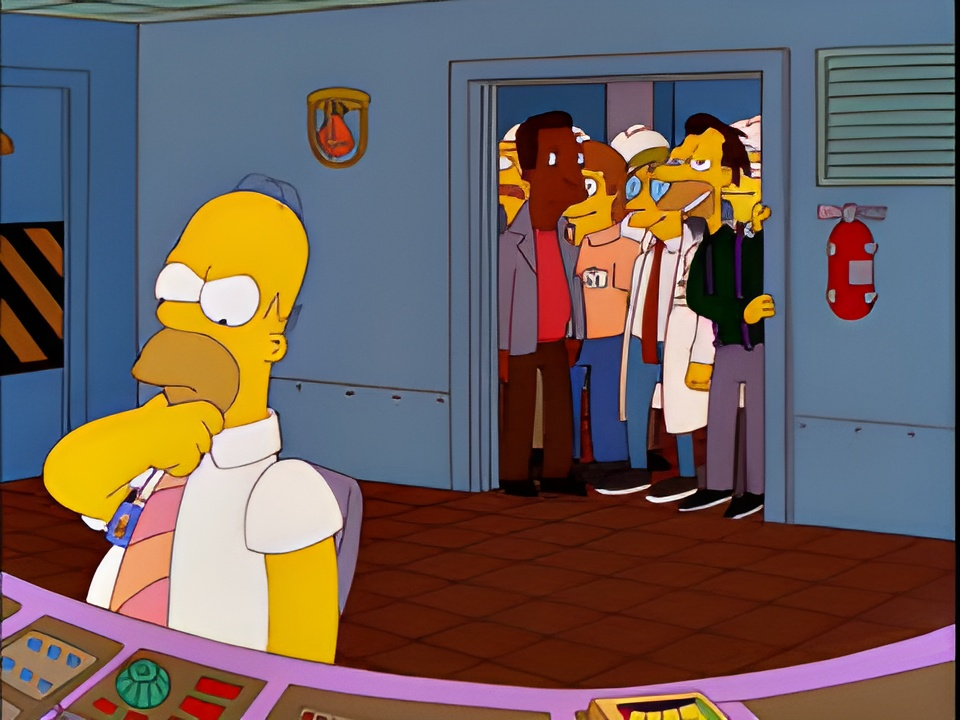

In [ ]:
img_original = cv2.imread("../LR/simpsons02.jpg")
img_resultado = cv2.imread("results/simpsons02_out.jpg")
cv2_imshow(img_original)
cv2_imshow(img_resultado)